In [1]:
from matplotlib import pyplot
import numpy
import time

# Set seed of random number generator for reproducibility
numpy.random.seed(123)

In [2]:
# imports from the pyfoomb package
import pyfoomb
print(f'Current package version of {pyfoomb.__name__}: {pyfoomb.__version__}')

from pyfoomb import BioprocessModel
from pyfoomb import ObservationFunction
from pyfoomb import Caretaker
from pyfoomb import Visualization
from pyfoomb import Measurement
from pyfoomb import TimeSeries
from pyfoomb import ParameterMapper
from pyfoomb import Helpers

C:\Users\hemmerich\AppData\Local\Continuum\miniconda3\envs\pyfoomb-dev\lib\site-packages\assimulo\solvers\odepack.py:701: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  N.array([[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],  # 5th order
Could not find GLIMDA.


Current package version of pyfoomb: 2.17.7


# Example bioprocess model

In [3]:
# Defines the model class
class GrowthCoupledProduction(BioprocessModel):       
    
    def specific_growth_rate_mu(self, S):
        kS = self.model_parameters['kS']
        mu_max = self.model_parameters['mu_max']
        kSI = self.model_parameters['kSI']
        mu = mu_max * S / (kS + S + S**2/kSI)
        return mu
    
    
    def specific_production_rate_qP(self, mu):
        YPX = self.model_parameters['YPX']
        qP = YPX * mu
        return qP
    
    
    def specific_substrate_consumption_rate_qS(self, mu, qP):
        YXS = self.model_parameters['YXS']
        YPS = self.model_parameters['YPS']
        qS = 1/YXS * mu + 1/YPS * qP
        return qS

    
    def rhs(self, t, y, sw=None):
        
        # Unpacks the state vector. The states are alphabetically ordered.
        P, S, X = y

        # Calculate specific rates
        mu = self.specific_growth_rate_mu(S)
        qP = self.specific_production_rate_qP(mu)
        qS = self.specific_substrate_consumption_rate_qS(mu, qP)

        # Calculate state derivatives
        dXdt = mu * X
        dSdt = -qS * X
        dPdt = qP * X
        
        return [dPdt, dSdt, dXdt]

In [4]:
model_parameters = {
    'kS' : 0.05,
    'kSI' : 75.0,
    'mu_max' : 0.4,
    'YXS' : 0.6,
    'YPS' : 0.4,
    'YPX' : 0.2,
}     

initial_values = {
    'S0' : 20.0,
    'X0' : 0.01,
    'P0' : 0.0,
}

We'll define two replicates, which differ in the initial substrate concentration to show the effect of the substate inhibition.

In [5]:
replicate_ids = ['1st', '2nd']

# Define mapping to make the initial values local parameters for the replicate_id
mappings = [
    ParameterMapper(replicate_id='1st', global_name='S0', value=25.0),
    ParameterMapper(replicate_id='1st', global_name='X0', value=0.01),
    ParameterMapper(replicate_id='1st', global_name='P0', value=0.0),
    ParameterMapper(replicate_id='2nd', global_name='S0', value=10.0),
    ParameterMapper(replicate_id='2nd', global_name='X0', value=0.01),
    ParameterMapper(replicate_id='2nd', global_name='P0', value=0.0),
    
]

As usual, create a `Caretaker` instance and run a forward simulation.

In [6]:
# Instantiates are caretaker with two replicate_ids
caretaker_1 = Caretaker(
    bioprocess_model_class=GrowthCoupledProduction, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
    replicate_ids=replicate_ids,
)

caretaker_1.apply_mappings(mappings)

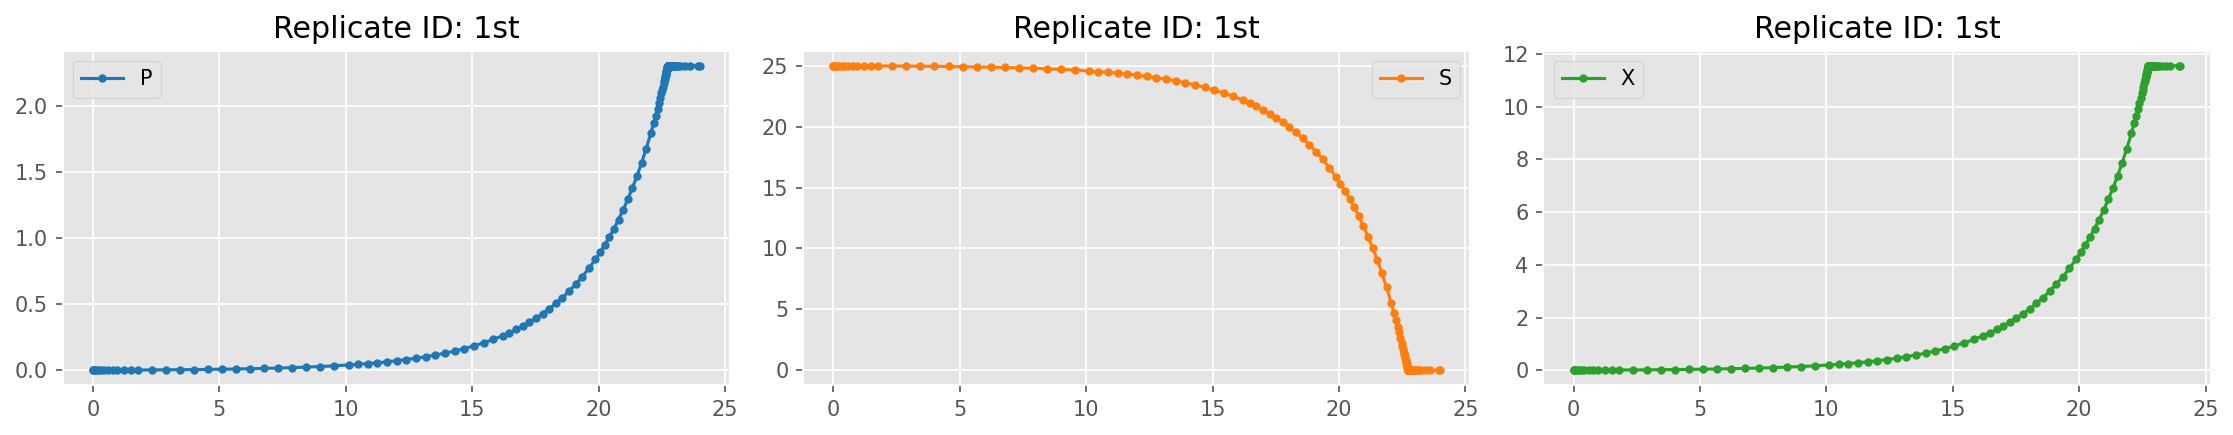

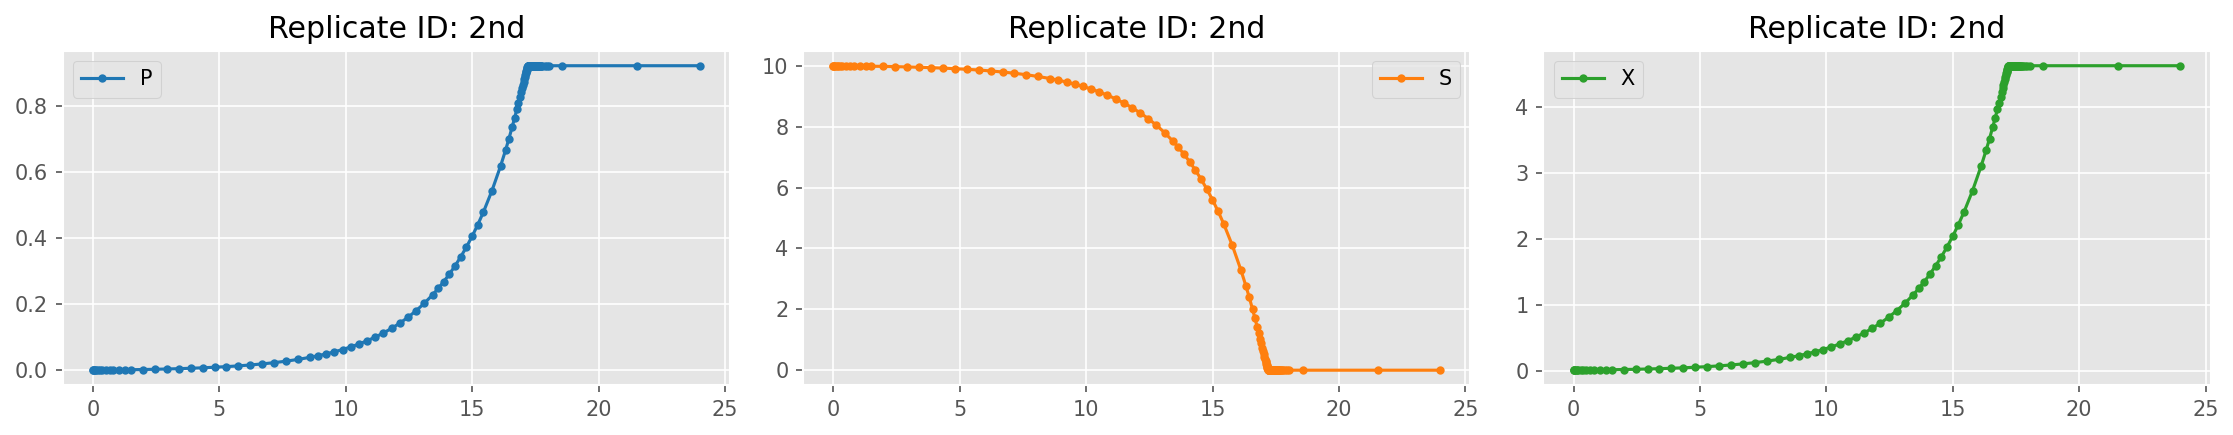

In [7]:
simulation = caretaker_1.simulate(t=24)
_ = Visualization.show_kinetic_data(simulation)

# Unleashing the power of programmatic control


Consider now we want to see how the specific rates (mu, qP and qS) develop over time for the two replicates. Although these are calculated in the right hand side of the differential equation system, these are not stored since the returned values for the right hand side are the derivatives in time for the state variables.

Since the `rhs` can be more often called than we actually would assume from the integration result, we will use the integration results to calculate the values for timepoints of the integration result.

To do so, we implement another method that takes the model states and uses the contained information (i.e., the integrated ODE states and integration times) to calculate the specific rates. The corresponding vectors are used to create `TimeSeries` objects.

This can be easily done by subclassing and implementation of a new method, thanks to the object-oriented approach of `pyFOOMB`.


In [8]:
# Defines the model class
class GrowthCoupledProductionSpecificRates(GrowthCoupledProduction):       
        
    def get_specific_rates_time_series(self, model_states:list):
        
        # Use the pyFOOMB Helpers method to get a specific TimeSeries object, specified by its `name` and `replicate_id`
        state_S = Helpers.extract_time_series(model_states, name='S', replicate_id=self.replicate_id)
        
        # Get the timepoints and values needed for specific rate calculation
        _t = state_S.timepoints
        _S = state_S.values
        
        # Calculate specific rates vectors
        _mu = self.specific_growth_rate_mu(_S)
        _qP = self.specific_production_rate_qP(_mu)
        _qS = self.specific_substrate_consumption_rate_qS(_mu, _qP)
        
        # Create new corresponding TimeSeries objects
        mu = TimeSeries(name='mu', replicate_id=self.replicate_id, timepoints=_t, values=_mu)
        qP = TimeSeries(name='qP', replicate_id=self.replicate_id, timepoints=_t, values=_qP)
        qS = TimeSeries(name='qS', replicate_id=self.replicate_id, timepoints=_t, values=_qS)
        
        return [mu, qP, qS]

In [9]:
# Instantiates a caretaker with two replicate_ids
caretaker_2 = Caretaker(
    bioprocess_model_class=GrowthCoupledProductionSpecificRates, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
    replicate_ids=replicate_ids,
)

caretaker_2.apply_mappings(mappings)

After having run a forward simulation, we obtain a list of `ModelState` objects. This list is then used as argument for the `get_specific_time_series()` method that is bound to each `BioprocessModel` subsclass instance. So we just iterate over all instances (one instance for one replicate id) and collect the corresponding `TimeSeries` objects.

In [10]:
simulation = caretaker_2.simulate(t=24)

# Now calculate all specific rates TimeSeries objects
specific_rates = []
for rid in caretaker_2.replicate_ids:
    specific_rates.extend(
        caretaker_2.simulators[rid].bioprocess_model.get_specific_rates_time_series(simulation)
    )
    
simulation_extended = [*simulation, *specific_rates]

# See the results

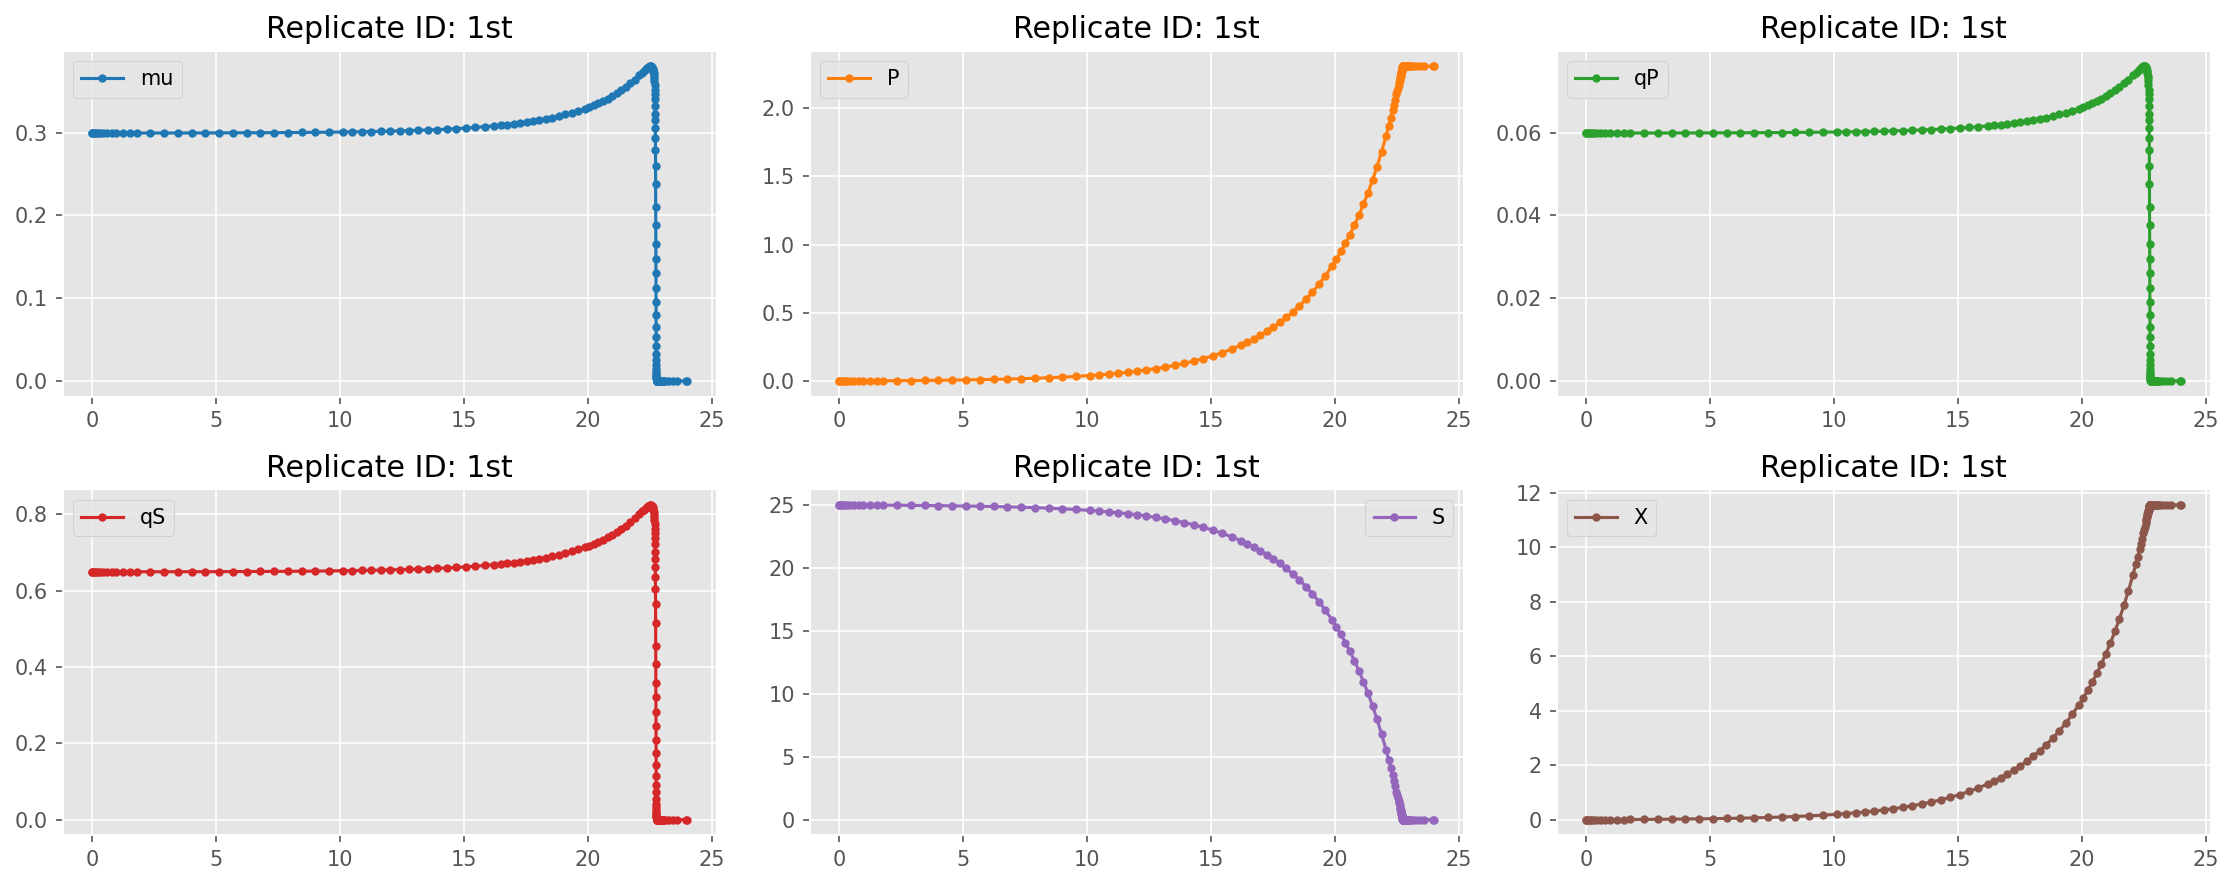

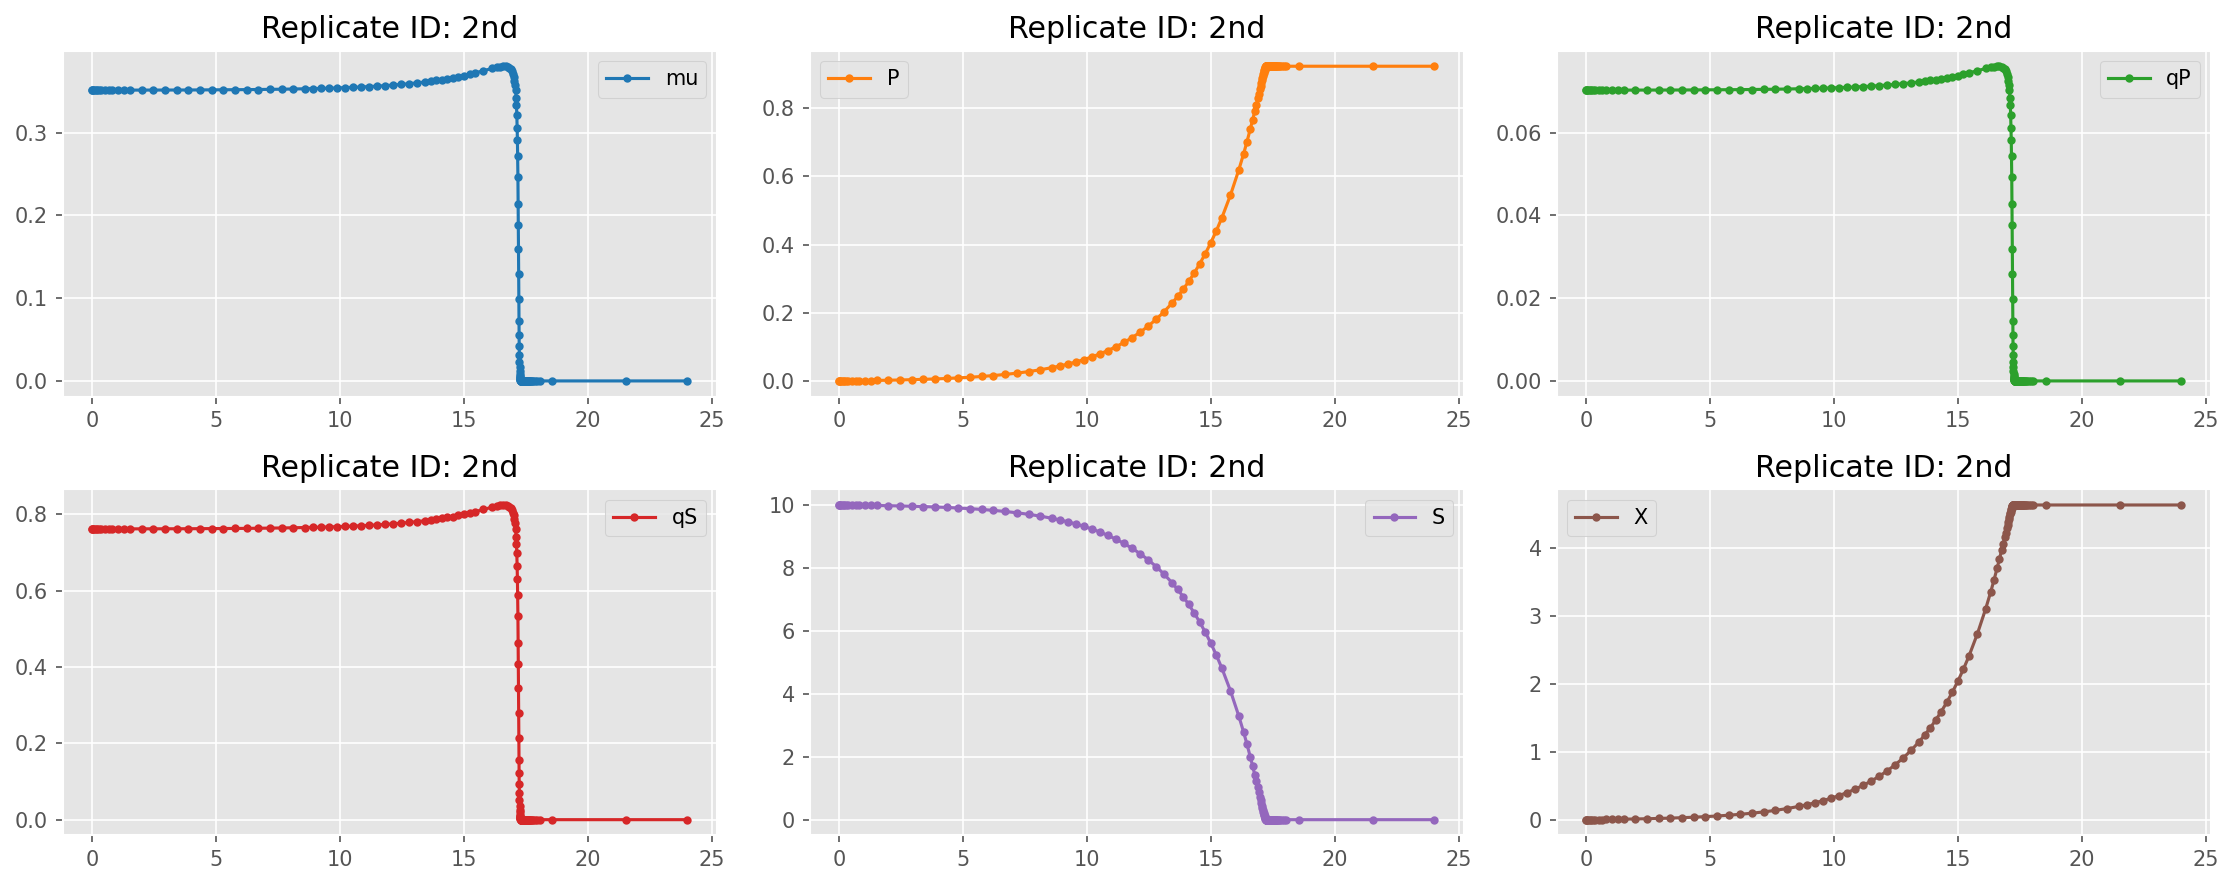

In [11]:
_ = Visualization.show_kinetic_data(simulation_extended)